In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/Stereo_Li_108c_test2.pth

In [1]:
import io
import torch
import torchaudio
import torchvision
import numpy as np
from datasets import load_dataset
from walloc import walloc
from IPython.display import display, Audio, Image, update_display, HTML
from torchvision.transforms import ToPILImage
from fastprogress.fastprogress import master_bar, progress_bar
from ioae import IsotropicOobleckAutoencoder
class Config: pass

In [2]:
def compress(x_valid, codec):
    compressed_data = codec.encoder(codec.wavelet_analysis(x_valid / 2, J=codec.J))
    return compressed_data

def decompress(compressed_data, codec):
    decompressed_data = 2*codec.clamp(codec.post(codec.wavelet_synthesis(codec.decoder(compressed_data), codec.J)))
    return decompressed_data

In [3]:
device = "cuda:2"

checkpoint = torch.load("Stereo_Li_108c_test2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec1D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode,
    post_filter = codec_config.post_filter
).to(device)
codec.load_state_dict(checkpoint['model_state_dict'])
codec.eval();

config = Config()
config.batch_size = 64
config.num_workers = 32
config.grad_accum_steps = 1
config.plot_update = 256
config.patience = 16
config.min_lr = 1e-7
config.max_lr = 1e-5
config.warmup_steps = 5000
config.weight_decay = 0.
config.epochs = 10
config.epoch_len = 10000


config.rate_reduction = 2**codec_config.J
config.aux_rr = 4
config.rate_reduction = config.aux_rr*config.rate_reduction
config.sequence_length = 256
config.length_samples = 2**18
config.length_samples = config.length_samples//(config.sequence_length*config.rate_reduction)
config.length_samples = config.sequence_length*config.rate_reduction*config.length_samples
config.patch_size = round(config.length_samples/(config.sequence_length*config.rate_reduction))
config.channels=codec_config.channels
config.embed_dim=192
config.depth=6

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
model = IsotropicOobleckAutoencoder(
    channels=codec_config.latent_dim,
    patch_size=config.patch_size,
    embed_dim=config.embed_dim,
    depth=config.depth,
).to(device)

sum(p.numel() for p in model.parameters())/1e6

6.71166

In [5]:
train_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='train')
valid_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='validation')

In [6]:
L = config.length_samples
C = config.channels
crop = torchvision.transforms.RandomCrop((2,L))
valid_crop = torchvision.transforms.CenterCrop((2,L))
def collate_fn(batch):
    B = len(batch)
    x = torch.zeros( (B, C, 2, L), dtype=torch.float32)
    i_sample = 0
    for i_sample, sample in enumerate(batch):
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'])
        audio_vocal, fs = torchaudio.load(sample['audio_vocal']['bytes'])
        audio_mix = audio_mix.unsqueeze(1)
        audio_vocal = audio_vocal.unsqueeze(1)
        audio = torch.cat([audio_mix,audio_vocal],dim=1)
        x[i_sample,:,:,:] = crop(audio)
    return x[:,:,0,:], x[:,:,1]

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros( (B, C, 2, L), dtype=torch.float32)
    i_sample = 0
    for i_sample, sample in enumerate(batch):
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'])
        audio_vocal, fs = torchaudio.load(sample['audio_vocal']['bytes'])
        audio_mix = audio_mix.unsqueeze(1)
        audio_vocal = audio_vocal.unsqueeze(1)
        audio = torch.cat([audio_mix,audio_vocal],dim=1)
        x[i_sample,:,:,:] = valid_crop(audio)
    return x[:,:,0,:], x[:,:,1,:]

In [7]:
resample_down = torchaudio.transforms.Resample(
    orig_freq=44100,
    new_freq=44100 // config.aux_rr
).to(device)
resample_up = torchaudio.transforms.Resample(
    orig_freq=44100 // config.aux_rr,
    new_freq=44100
).to(device)

In [8]:
with torch.no_grad():
    valid_batch = valid_dataset[200:201]
    valid_batch = [dict(zip(valid_batch.keys(), values)) for values in zip(*valid_batch.values())]
    x_valid, v_valid = valid_collate_fn(valid_batch)
    x_valid = resample_down(x_valid.to(device))
    x_valid = compress(x_valid, codec)

/home/dgj335/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:1466: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  resampled = torch.nn.functional.conv1d(waveform[:, None], kernel, stride=orig_freq)
/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [9]:
def make_spectrogram(X):
    X = spectrogram(X).log()
    X = X - X.mean()
    X = X/X.std()
    X = X/3
    X = X.clamp(-0.5,0.5)
    X = X + 0.5
    return ToPILImage()(X)

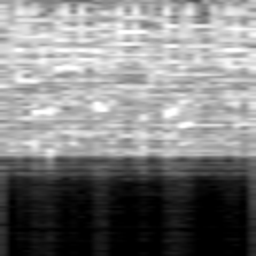

In [10]:
with torch.no_grad():
    spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=44100,
        n_fft=4096,
    ).to(device)
    SG = make_spectrogram(
        decompress(x_valid,codec)
        [0,0].to(device))
SG.resize((256,256))

In [11]:
with torch.no_grad():
    display(Audio(
        resample_up(decompress(x_valid,codec)).to("cpu").numpy()[0],
        rate=44100
    ))

In [12]:
optimizer = torch.optim.AdamW(
    [
        {'params': model.parameters()},
        {'params': codec.post.parameters()}
    ],
    weight_decay=config.weight_decay,
    lr=config.min_lr  # Global learning rate for the other parameters
)


def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

In [ ]:
losses = []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
model.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    sampler = torch.utils.data.RandomSampler(
        train_dataset,
        replacement=True,
        num_samples=config.epoch_len*config.batch_size
    )
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        sampler=sampler,
        drop_last=True,
        collate_fn=collate_fn
    )
   
    for i, (x,v) in enumerate(progress_bar(dataloader, parent=mb)):
        x = compress(resample_down(x.to(device)), codec)
        v = v.to(device)
        pred = resample_up(decompress(model(x),codec))
        mse_loss = torch.nn.functional.mse_loss(pred, v)
        losses.append(np.log10(mse_loss.item()))
        mse_loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(losses) % config.plot_update == 0:
            plot_n = len(losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(losses))
            dist_y = losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                model.eval()
                y_valid = resample_up(decompress(model(x_valid),codec))[0]
                torchaudio.save(f"valid_{device}.wav", src=y_valid.to("cpu"), sample_rate=44100)
                buffer = io.BytesIO()
                make_spectrogram(y_valid).resize((256,256)).save(buffer, format="PNG")
                model.train()
            buffer.seek(0)
            if len(img_displays) == 0:
                img_displays.append(display(Image(buffer.read()), display_id=True))
            else:
                update_display(Image(buffer.read()), display_id=img_displays[0].display_id)
        i_step+=1
        
    torch.save({
        'model_state_dict': model.state_dict(),
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'train_loss': losses,
        'config': config
    }, f"log_{device}.pth")

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:797: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose1d(
/home/dgj335/.local/lib/python3.10/site-packages/pytorch_wavelets/dwt/lowlevel.py:253: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + \
/home/dgj335/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/A

In [ ]:
from IPython.display import display, Image, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'codec_state_dict': codec.state_dict(),
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'train_loss': losses,
    'config': config
}, f"../../hf/LCCL/vss_walloc_5x.pth")